Paired TAM (transcient abnormal myleoproliferation) vs AML (acute myeloid leukemia) analysis of patients with the co-occuring condition of Down Syndrome using DESeq2 on IJC counts obtained from rMATS analysis.

Using a matrix constructed from Kids First Workflow V4 done on single runs, a series of scripts were created and are stored in this repository.  For each of the splicing types, all the runs considered for analysis are pooled and normalized to have a non-redundant set of splicing events.  A matrix is then constructed for each of the samples to be analyzed.  

Each splicing type has a bed file for visualizaiton in UCSC Genome browser of all the events, as well as created a matrix of the single runs normalized to the non-redundant union of files.  Both the source and the normalized bed file are available to ensure interprebility of results. 

Using associative arrays in an awk script, it was a rapid way to transform the individual counts from each of the individual runs into a matrix that facilitated analysis.

Using annotations obtained from the rMATS run that provided the coordinates of each of the splicing events as well as the gene that the junctions came from and the count of the reads that overlapped the junctions.   
 
Limma in this notebook is used to perform analysis of these junction counts provided by the rMATS routine.  Using these counts as junction expression.

Between the splicing event differences and the expression differences, between paired samples, biological functional differences may be obtained.

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")


Bioconductor version '3.18' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install



In [2]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'bbmle', 'BH', 'BiocManager', 'bslib', 'cachem', 'cli', 'coda',
  'codetools', 'cpp11', 'crayon', 'crosstalk', 'curl', 'data.table', 'DESeq2',
  'digest', 'edgeR', 'evaluate', 'farver', 'fastmap', 'GenomeInfoDb',
  'ggplot2', 'gtable', 'highr', 'htmlwidgets', 'KernSmooth', 'knitr',
  'lifecycle', 'locfit', 'munsell', 'mvtnorm', 'nlme', 'openssl', 'plotly',
  'RcppArmadillo', 'repr', 'rlang', 'rmarkdown', 'S4Arrays', 'scales',
  'segmented', 'SparseArray', 'stringi', 'stringr', 'survival', 'tidyselect',
  'tinytex', 'withr', 'xfun', 'zlibbioc'



In [3]:
library(Glimma)
library(dplyr)
library(edgeR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma



In [4]:
setwd("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/TAM.AML.all/A3SS_calculate")

In [5]:
getwd()


[1] "/Users/annedeslattesmays/Scitechcon Dropbox/Anne DeslattesMays/projects/post-rmats-single-run/TAM.AML.all/A3SS_calculate"

In [6]:
cts <- as.matrix(read.csv("A3SS.IJC.w.coordinates.matrix.csv",sep=",",row.names="ID"))

In [7]:
dim(cts)

[1] 14527   126

In [8]:
cts[1:3,11:dim(cts)[2]]

,PASNSP.03A,PASWXF.03A,PASXCL.03A,PASXFP.03A,PASZBH.03A,PATBFK.03A,PATDXB.03A,PATHYW.03A,PATJSM.03A,PATJTW.03A,⋯,PAYEGL.03A,PAYFEJ.03A,PAYFLR.03A,PAYJHN.03A,PAYJHS.03A,PAYLHE.03A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,19,0,0,0,0,0,0,0,0,0,⋯,0,0,0,9,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [9]:
featureData <- data.frame(cts[,1:10])
featureData[1:3,]

,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761,chr1,+,100078450,100080659,100080495,100080659,100067976,100068195
2,ENSG00000283761.1,ENSG00000283761,chr1,+,100078450,100080659,100080495,100080659,100077164,100077277
3,ENSG00000122435.11,TRMT13,chr1,+,100140407,100141019,100140851,100141019,100140181,100140251


In [10]:
featureData <- featureData[,c(1,2)]

In [11]:
head(featureData,2)

,GeneID,geneSymbol
,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761
2,ENSG00000283761.1,ENSG00000283761


In [12]:
cts <- data.matrix(cts[,11:dim(cts)[2]])
mode(cts) <- "integer"
is.integer(cts)

[1] TRUE

In [13]:
dim(cts)
head(cts,2)

[1] 14527   116

,PASNSP.03A,PASWXF.03A,PASXCL.03A,PASXFP.03A,PASZBH.03A,PATBFK.03A,PATDXB.03A,PATHYW.03A,PATJSM.03A,PATJTW.03A,⋯,PAYEGL.03A,PAYFEJ.03A,PAYFLR.03A,PAYJHN.03A,PAYJHS.03A,PAYLHE.03A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,19,0,0,0,0,0,0,0,0,0,⋯,0,0,0,9,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [14]:
colnames(cts)

[1] "PASNSP.03A"     "PASWXF.03A"     "PASXCL.03A"     "PASXFP.03A"    
  [5] "PASZBH.03A"     "PATBFK.03A"     "PATDXB.03A"     "PATHYW.03A"    
  [9] "PATJSM.03A"     "PATJTW.03A"     "PATMYU.03A"     "PATSAA.03A"    
 [13] "PATSBU.03A"     "PATUHH.03A"     "PATYHN.03A"     "PAUCCI.03A"    
 [17] "PAUCWF.03A"     "PAUFEM.03A"     "PAUGFW.03A"     "PAUGSR.03A"    
 [21] "PAUIRS.03A"     "PAUJSX.03A"     "PAUJUA.03A"     "PAUKTL.03A"    
 [25] "PAUMEU.03A"     "PAURGT.03A"     "PAURGZ.03A"     "PAUUSG.03A"    
 [29] "PAUVKB.03A"     "PAUVKY.03A"     "PAUVKY.40A"     "PAUWDM.03A"    
 [33] "PAUWDN.03A"     "PAUWWN.03A"     "PAUXAT.03A"     "PAUXEH.03A"    
 [37] "PAUYAY.03A"     "PAVCVG.03A"     "PAVDZT.03A"     "PAVECW.03A"    
 [41] "PAVESU.03A"     "PAVIIZ.03A"     "PAVKZU.03A"     "PAVLZB.03A"    
 [45] "PAVMSZ.03A"     "PAVNSJ.03A"     "PAVNXY.03A"     "PAVPJC.03A"    
 [49] "PAVRGG.03A"     "PAVVPL.03A"     "PAVWDK.03A"     "PAVWVF.03A"    
 [53] "PAVXBW.03A"     "PAWBDC.03A"     "PAWCAY.03A"     "PAWCPC.03A"    
 [57] "PAWDIN.03A"     "PAWEUI.03A"     "PAWFKB.03A"     "PAWGFN.03A"    
 [61] "PAWGHI.03A"     "PAWGIG.03A"     "PAWHHS.03A"     "PAWHSD.03A"    
 [65] "PAWHSD.40A"     "PAWIAD.03A"     "PAWJDZ.03A"     "PAWKFB.03A"    
 [69] "PAWRJN.03A"     "PAWSIP.03A"     "PAWSNZ.03A"     "PAWSNZ.40A"    
 [73] "PAWSUI.03A"     "PAWVNF.03A"     "PAWVRU.03A"     "PAWWPI.03A"    
 [77] "PAWXEX.03A"     "PAWXPM.03A"     "PAWYII.03A"     "PAWYKF.03A"    
 [81] "PAXAWN.03A"     "PAXBAL.03A"     "PAXBFM.03A"     "PAXCUK.03A"    
 [85] "PAXDHB.03A"     "PAXDWD.03A"     "PAXGLA.03A"     "PAXHDZ.03A"    
 [89] "PAXHVP.03A"     "PAXHYL.03A"     "PAXJYG.03A"     "PAXKRG.03A"    
 [93] "PAXNFN.03A"     "PAXNKT.03A"     "PAXPLA.03A"     "PAXSBH.03A"    
 [97] "PAXSSI.03A"     "PAXWGW.03A"     "PAXWZW.03A"     "PAXXCC.03A"    
[101] "PAXZJT.03A"     "PAXZLD.03A"     "PAYAXU.03A"     "PAYDIX.03A"    
[105] "PAYDXU.03A"     "PAYDYT.03A"     "PAYEGL.03A"     "PAYFEJ.03A"    
[109] "PAYFLR.03A"     "PAYJHN.03A"     "PAYJHS.03A"     "PAYLHE.03A"    
[113] "X_1_PAUTLA.03A" "X_1_PAUTLA.40A" "X_1_PAVUDU.03A" "X_1_PAVUDU.40A"

In [15]:
colnames(cts[,c(113:116)])

[1] "X_1_PAUTLA.03A" "X_1_PAUTLA.40A" "X_1_PAVUDU.03A" "X_1_PAVUDU.40A"

I tried to rename colnames but it did not rename the existing object, rather it created a new object.

From code co-pilot: The issue with your code arises from the fact that when you use subsetting in R with cts[, c(113:116)], it returns a new object, and changing the column names of this new object does not affect the original data frame. To reassign the column names in the original data frame, you need to directly access and modify the colnames attribute of the cts data frame.


In [16]:
# Assign new column names directly to the specified columns
colnames(cts)[c(113:116)] <- c("PAUTLA.03A", "PAUTLA.40A", "PAVUDU.03A", "PAVUDU.40A")

# Verify the column names
colnames(cts)[c(113:116)]

[1] "PAUTLA.03A" "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

The PAWHSD samples are not TAM and AML but in fact TAM and TAM - the resulting heatmap when included showed they clustered together.  We will eliminate them from subsequent analyses.   To find and replace we need to work on the existing object. Get the mask object (which columns equal PAWHSD).

In [17]:
dim (cts)
# Find column numbers for column names that contain "PAWHSD"
column_numbers <- grep("PAWHSD", colnames(cts))

# Remove these columns from the cts data frame
cts <- cts[, -column_numbers]
dim(cts)

[1] 14527   116

[1] 14527   114

In [20]:
coldata <- read.csv("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/design/design_all_matrix.csv", row.names=1)

In [21]:
head(coldata)

,patient,condition,paired
,<chr>,<chr>,<chr>
PAUVKY.03A,PAUVKY,preAML,yes
PAUVKY.40A,PAUVKY,AML,yes
PAUTLA.03A,PAUTLA,preAML,yes
PAUTLA.40A,PAUTLA,AML,yes
PAVUDU.03A,PAVUDU,preAML,yes
PAVUDU.40A,PAVUDU,AML,yes


In [22]:
# Create a new column 'name' with rownames
coldata$name <- rownames(coldata)
head(coldata)

,patient,condition,paired,name
,<chr>,<chr>,<chr>,<chr>
PAUVKY.03A,PAUVKY,preAML,yes,PAUVKY.03A
PAUVKY.40A,PAUVKY,AML,yes,PAUVKY.40A
PAUTLA.03A,PAUTLA,preAML,yes,PAUTLA.03A
PAUTLA.40A,PAUTLA,AML,yes,PAUTLA.40A
PAVUDU.03A,PAVUDU,preAML,yes,PAVUDU.03A
PAVUDU.40A,PAVUDU,AML,yes,PAVUDU.40A


In [23]:
# Extract patient names for each condition
patients_TAM <- coldata$name[coldata$condition == "TAM"]
patients_preAML <- coldata$name[coldata$condition == "preAML"]
patients_AML <- coldata$name[coldata$condition == "AML"]

patients_TAM
patients_preAML
patients_preAML

[1] "PASNSP.03A" "PASWXF.03A" "PASXCL.03A" "PASXFP.03A" "PASZBH.03A"
 [6] "PATBFK.03A" "PATDXB.03A" "PATHYW.03A" "PATJSM.03A" "PATJTW.03A"
[11] "PATMYU.03A" "PATSAA.03A" "PATSBU.03A" "PATUHH.03A" "PATYHN.03A"
[16] "PAUCCI.03A" "PAUCWF.03A" "PAUFEM.03A" "PAUGFW.03A" "PAUGSR.03A"
[21] "PAUIRS.03A" "PAUJSX.03A" "PAUJUA.03A" "PAUKTL.03A" "PAUMEU.03A"
[26] "PAURGT.03A" "PAURGZ.03A" "PAUUSG.03A" "PAUVKB.03A" "PAUWDM.03A"
[31] "PAUWDN.03A" "PAUXAT.03A" "PAUXEH.03A" "PAUYAY.03A" "PAVCVG.03A"
[36] "PAVDZT.03A" "PAVECW.03A" "PAVESU.03A" "PAVIIZ.03A" "PAVKZU.03A"
[41] "PAVMSZ.03A" "PAVNSJ.03A" "PAVNXY.03A" "PAVPJC.03A" "PAVRGG.03A"
[46] "PAVVPL.03A" "PAVWVF.03A" "PAWBDC.03A" "PAWCAY.03A" "PAWCPC.03A"
[51] "PAWDIN.03A" "PAWEUI.03A" "PAWFKB.03A" "PAWGFN.03A" "PAWGHI.03A"
[56] "PAWGIG.03A" "PAWHHS.03A" "PAWIAD.03A" "PAWJDZ.03A" "PAWKFB.03A"
[61] "PAWRJN.03A" "PAWSIP.03A" "PAWSUI.03A" "PAWVNF.03A" "PAWVRU.03A"
[66] "PAWWPI.03A" "PAWXEX.03A" "PAWXPM.03A" "PAWYII.03A" "PAWYKF.03A"
[71] "PAXAWN.03A" "PAXBAL.03A" "PAXBFM.03A" "PAXCUK.03A" "PAXDHB.03A"
[76] "PAXGLA.03A" "PAXHDZ.03A" "PAXHVP.03A" "PAXHYL.03A" "PAXJYG.03A"
[81] "PAXNFN.03A" "PAXNKT.03A" "PAXPLA.03A" "PAXSBH.03A" "PAXSSI.03A"
[86] "PAXWGW.03A" "PAXWZW.03A" "PAXXCC.03A" "PAXZLD.03A" "PAYAXU.03A"
[91] "PAYDIX.03A" "PAYDXU.03A" "PAYDYT.03A" "PAYEGL.03A" "PAYFEJ.03A"
[96] "PAYFLR.03A" "PAYJHN.03A" "PAYJHS.03A" "PAYLHE.03A"

[1] "PAUVKY.03A" "PAUTLA.03A" "PAVUDU.03A" "PAWSNZ.03A" "PAUWWN.03A"
 [6] "PAVLZB.03A" "PAVWDK.03A" "PAVXBW.03A" "PAXDWD.03A" "PAXKRG.03A"
[11] "PAXZJT.03A"

[1] "PAUVKY.03A" "PAUTLA.03A" "PAVUDU.03A" "PAWSNZ.03A" "PAUWWN.03A"
 [6] "PAVLZB.03A" "PAVWDK.03A" "PAVXBW.03A" "PAXDWD.03A" "PAXKRG.03A"
[11] "PAXZJT.03A"

In [24]:
# Ensure the column names are character vectors
patients_TAM <- as.character(patients_TAM)
patients_preAML <- as.character(patients_preAML)
patients_AML <- as.character(patients_AML)

# Ensure colnames of cts match the 'name' column in design_all_matrix
# Assuming 'cts' is already loaded in the R environment
#matching_cols <- colnames(cts) %in% 

all(coldata$name %in% colnames(cts))


[1] TRUE

In [25]:
missing_names <- coldata$name[!coldata$name %in% colnames(cts)]

# Print the missing names
cat("The following names are missing from cts:\n")
print(missing_names)


The following names are missing from cts:
character(0)


This is an interesting catch - this was an inadvertant add -- I had removed it from all the references so I don't include it going forward.  But did not remove it from the design matrix.

In [26]:
# Create sub-matrices based on these patient names
cts_TAM <- cts[, colnames(cts) %in% patients_TAM, drop = FALSE]
cts_preAML <- cts[, colnames(cts) %in% patients_preAML, drop = FALSE]
cts_AML <- cts[, colnames(cts) %in% patients_preAML, drop = FALSE]


# Print summaries of the sub-matrices to verify
cat("Dimensions of cts_TAM:\n")
print(dim(cts_TAM))
cat("\nFirst few rows of cts_TAM:\n")
print(head(cts_TAM))

cat("\nDimensions of cts_preAML:\n")
print(dim(cts_preAML))
cat("\nFirst few rows of cts_preAML:\n")
print(head(cts_preAML))

cat("\nDimensions of cts_AML:\n")
print(dim(cts_AML))
cat("\nFirst few rows of cts_AML:\n")
print(head(cts_AML))

Dimensions of cts_TAM:
[1] 14527    99

First few rows of cts_TAM:
  PASNSP.03A PASWXF.03A PASXCL.03A PASXFP.03A PASZBH.03A PATBFK.03A PATDXB.03A
1         19          0          0          0          0          0          0
2          0          0          0          0          0          0          0
3          0          0          0          0          0          0          0
4         51         51         40         36         59         23         44
5          0          0          0          0          0          0          0
6         51         54         41          0          0         22          0
  PATHYW.03A PATJSM.03A PATJTW.03A PATMYU.03A PATSAA.03A PATSBU.03A PATUHH.03A
1          0          0          0          0          0          0          0
2          0          0          0          0          0          0          0
3          0          0          0          0          0          0          0
4         51         36         75         47         48        

In [62]:
sum(rowSums(cts_preAML) > 1000)

[1] 2004

**Key Points:**

1. **Threshold Definition:** Define a count threshold (e.g., 1000).
2. **Criteria for Selection:** Define a function to select rows that have counts above the threshold in at least half of the samples in each condition.
3. **Row Selection:** Apply this criteria to each condition's sub-matrix.
4. **Combine Rows:** Combine the selected rows from all conditions to form the final matrix.
5. **MDS Plot:** Proceed with the MDS plot using the final matrix.
This approach ensures that the rows included in the final matrix have significant counts in most of the samples for each condition, which should help to maximize the differences in the signals.

Dimensions of the final matrix:
[1] 481 114
[1] "AML_yes"    "preAML_no"  "preAML_yes" "TAM_no"    


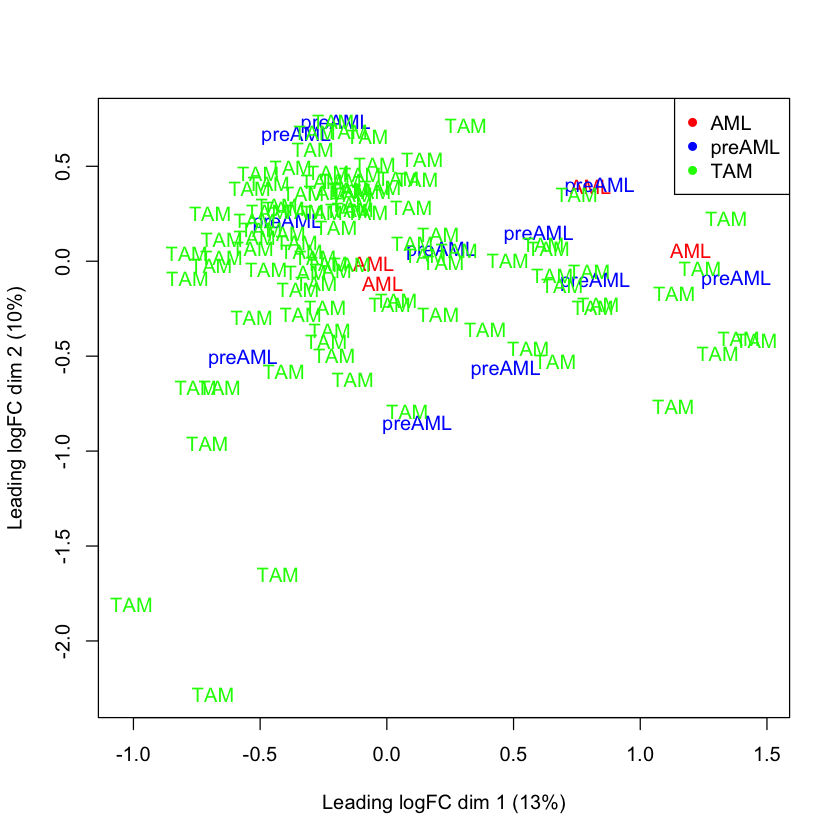

In [69]:
# Create sub-matrices based on these patient names
patients_TAM <- coldata$name[coldata$condition == "TAM"]
patients_preAML <- coldata$name[coldata$condition == "preAML"]
patients_AML <- coldata$name[coldata$condition == "AML"]

cts_TAM <- cts[, colnames(cts) %in% patients_TAM, drop = FALSE]
cts_preAML <- cts[, colnames(cts) %in% patients_preAML, drop = FALSE]
cts_AML <- cts[, colnames(cts) %in% patients_AML, drop = FALSE]

# Define the threshold for counts and the criteria for "most"
threshold <- 10
min_samples <- function(mat) {
  apply(mat, 1, function(row) sum(row > threshold) >= (ncol(mat) / 2))
}

# Apply the criteria to each sub-matrix
preAML_rows_condition <- min_samples(cts_preAML)
TAM_rows_condition <- min_samples(cts_TAM)
AML_rows_condition <- min_samples(cts_AML)

# Combine the selected rows from all conditions
combined_condition <- preAML_rows_condition | TAM_rows_condition | AML_rows_condition
final_matrix <- cts[combined_condition, ]

# Print the dimensions of the final matrix to verify
cat("Dimensions of the final matrix:\n")
print(dim(final_matrix))

# Proceed with the analysis (e.g., MDS plot)
# Create a combined factor for the conditions and paired status
coldata$group <- factor(paste(coldata$condition, coldata$paired, sep = "_"))

# Check the levels of the group factor
print(levels(coldata$group))

# Proceed with the analysis (e.g., MDS plot)
# Create a factor for the conditions
coldata$condition <- factor(coldata$condition)

# Filter coldata to match the final matrix columns
coldata_filtered <- coldata[coldata$name %in% colnames(final_matrix), ]
        
# Convert the count data to a DGEList object
dge <- DGEList(counts = final_matrix)

# Normalize the data using the TMM method
dge <- calcNormFactors(dge)

# Compute the log-transformed counts per million (CPM)
logCPM <- cpm(dge, log=TRUE, prior.count=3)

# Define colors for each condition
condition_colors <- as.numeric(coldata_filtered$condition)
color_palette <- c("red", "blue", "green")
colors <- color_palette[condition_colors]

# Create MDS plot with colors for each condition
plotMDS(logCPM, col=colors, labels=coldata_filtered$condition, top=500)
legend("topright", legend=levels(coldata_filtered$condition), col=color_palette, pch=16)


In [70]:
# Save the sub-matrices to CSV files
write.csv(cts_TAM, "A3SS_cts_TAM.csv", row.names = FALSE)
write.csv(cts_preAML, "A3SS_cts_preAML.csv", row.names = FALSE)
write.csv(cts_AML, "A3SS_cts_AML.csv", row.names = FALSE)


In [71]:
cts <- final_matrix

featureData <- featureData[rownames(cts),]

In [72]:
dim(cts)
dim(featureData)

[1] 481 114

[1] 481   2

## Explanation
1. **Library loading:** We load the limma and edgeR libraries required for the analysis.
2. **Group factor:** We create a factor group based on the condition column in coldata.
3. **Design matrix:** We create a design matrix using model.matrix where each column corresponds to a condition.
4. **Contrast matrix:** We define a contrast matrix using makeContrasts for the comparisons of interest.
5. **DGEList object:** We convert the count data to a DGEList object and normalize it.
6. **Voom transformation:** We apply the voom transformation to the normalized data.
7. **Linear model fitting:** We fit a linear model to the transformed data using lmFit.
8. **Contrast fitting:** We apply the contrasts to the fitted model using contrasts.fit.
9. **eBayes:** We compute the statistics using eBayes.
10. **TopTable:** We extract the top differentially expressed genes for each comparison using topTable.

In [73]:
# Load necessary libraries
library(limma)
library(edgeR)
library(statmod)

# Load the design_all_matrix.csv file into coldata
coldata <- read.csv("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/design/design_all_matrix.csv", row.names=1)

# Create a new column 'name' with rownames
coldata$name <- rownames(coldata)

# Verify that all names in coldata are present in the column names of cts
if (!all(coldata$name %in% colnames(cts))) {
  stop("Not all names in coldata are present in the column names of cts")
}

# Filter coldata to only include names present in cts
coldata <- coldata[coldata$name %in% colnames(cts), ]

# Assuming cts is your count matrix and coldata is your sample information
# Make sure coldata$name matches the column names of cts
all(coldata$name %in% colnames(cts)) # This should return TRUE


[1] TRUE

In [74]:
# Ensure that the column names of cts are in the same order as the rownames of coldata
cts <- cts[, coldata$name]

# Create a factor for the conditions
group <- factor(coldata$condition)

# Create the design matrix
design <- model.matrix(~0 + group)
colnames(design) <- levels(group)

# Print the design matrix to verify
head(design)

# Define the contrast matrix for the comparisons
# We want to compare TAM vs preAML, TAM vs AML, preAML vs AML
contrast_matrix <- makeContrasts(
  TAM_vs_preAML = TAM - preAML,
  TAM_vs_AML = TAM - AML,
  preAML_vs_AML = preAML - AML,
  levels = design
)

# Print the contrast matrix to verify
print(contrast_matrix)

# Convert the count data to a DGEList object
dge <- DGEList(counts = cts)

# normalize and filter
keep          <-filterByExpr(dge, design)

is.logical(keep)
sum(keep==TRUE)

dge          <- dge         [keep,,keep.lib.size=FALSE]

# Normalize the data using the TMM method
dge <- calcNormFactors(dge)


,AML,preAML,TAM
1,0,1,0
2,1,0,0
3,0,1,0
4,1,0,0
5,0,1,0
6,1,0,0


        Contrasts
Levels   TAM_vs_preAML TAM_vs_AML preAML_vs_AML
  AML                0         -1            -1
  preAML            -1          0             1
  TAM                1          1             0


[1] TRUE

[1] 481

## Key Points
1. **Check Levels:** Print the levels of the group factor to ensure it is being created correctly.
2. **Color Palette:** Use a color palette that matches the number of unique groups.
3. **Legend:** Ensure that the legend matches the levels of the group factor.
   
This code will:

1. Load the coldata and ensure the row names match the column names of cts.
2. Create a new group factor combining the condition and paired status.
3. Verify the levels of the group factor.
4. Normalize the count data and compute log-transformed CPM values.
5. Generate an MDS plot with colors representing each unique group.
6. Add a legend to the plot corresponding to the group levels.

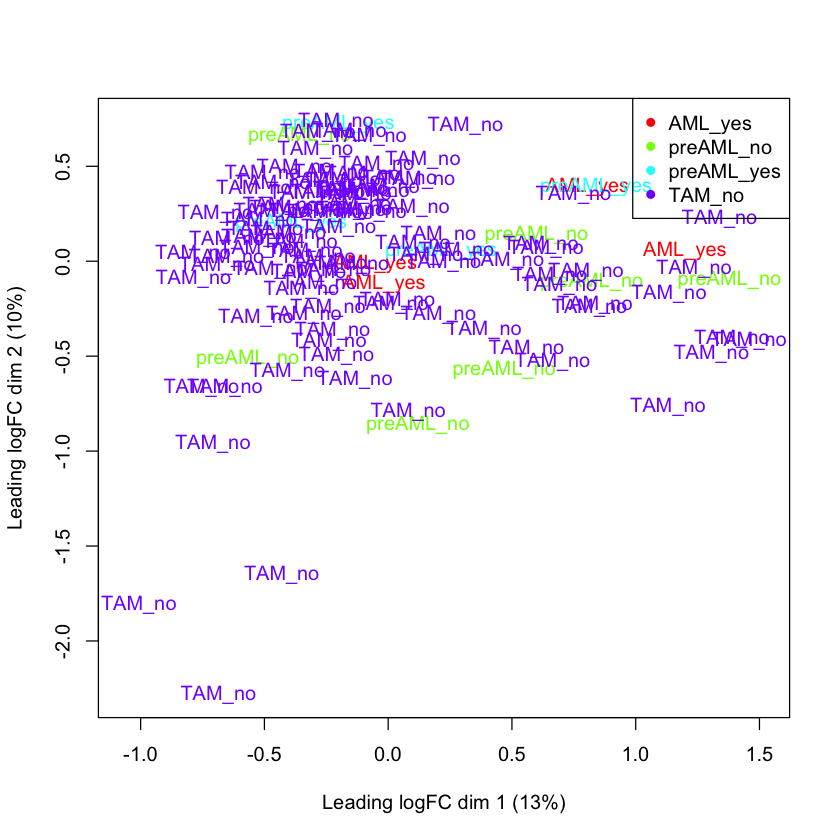

In [75]:
# Compute the log-transformed counts per million (CPM)
logCPM <- cpm(dge, log=TRUE, prior.count=3)

# Create a combined factor for the conditions and paired status
coldata$group <- factor(paste(coldata$condition, coldata$paired, sep = "_"))

# Define colors for each condition and paired status
condition_colors <- as.numeric(coldata$group)
color_palette <- rainbow(length(unique(coldata$group)))
colors <- color_palette[condition_colors]

# Create MDS plot with colors for each condition and paired status
plotMDS(logCPM, col=colors, labels=coldata$group, top=500)
legend("topright", legend=levels(coldata$group), col=color_palette, pch=16)

In [76]:

fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)


# Apply contrasts
fit2 <- contrasts.fit(fit, contrast_matrix)

# Compute the statistics
fit2 <- eBayes(fit2)

# Print the top differentially expressed genes for each comparison
TAM_vs_preAML_results <- topTable(fit2, coef = "TAM_vs_preAML", n=Inf)
TAM_vs_AML_results <- topTable(fit2, coef = "TAM_vs_AML",n=Inf)
preAML_vs_AML_results <- topTable(fit2, coef = "preAML_vs_AML",n=Inf)

TAM_vs_preAML_lookup <- rownames(TAM_vs_preAML_results)
TAM_vs_AML_lookup <- rownames(TAM_vs_AML_results)
preAML_vs_AML_lookup <- rownames(preAML_vs_AML_results)

length(TAM_vs_preAML_lookup)
length(TAM_vs_AML_lookup)
length(preAML_vs_AML_lookup)

[1] 481

[1] 481

[1] 481

In [77]:
head(TAM_vs_preAML_results,10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14203,0.7187102,9.674744,3.809452,0.0002273802,0.09105729,0.38492150
13938,0.3559367,9.940651,3.665168,0.0003786166,0.09105729,-0.03954368
2454,-0.4269117,11.642275,-3.198185,0.0017961037,0.14882239,-1.32546581
6177,2.7484135,5.782619,3.086988,0.0025458548,0.14882239,-1.61086729
5998,0.4714142,10.065924,3.055400,0.0028066264,0.14882239,-1.69042352
3802,-0.4020426,11.134630,-3.047815,0.0028728258,0.14882239,-1.70942731
609,0.5723057,9.867470,3.030065,0.0030334124,0.14882239,-1.75374189
2455,-0.4212753,12.763972,-3.013775,0.0031880538,0.14882239,-1.79422259
2776,-0.4160393,9.768459,-3.004645,0.0032778813,0.14882239,-1.81683219


In [78]:
head(TAM_vs_AML_results,10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9366,-3.4270223,2.781468,-4.761955,5.751553e-06,0.002766497,3.5391791
195,1.3986033,8.568684,3.531039,6.009643e-04,0.144531918,-0.4075779
3758,0.8726998,10.518821,3.221470,1.667760e-03,0.165130740,-1.2600012
1026,-0.6124977,9.992481,-3.166964,1.982652e-03,0.165130740,-1.4035566
3376,1.1623507,9.597572,3.151079,2.084345e-03,0.165130740,-1.4450190
12556,0.7558502,8.926336,3.065734,2.718716e-03,0.165130740,-1.6648297
3295,0.9689421,11.084666,3.042011,2.924450e-03,0.165130740,-1.7250416
2428,-0.5168502,13.776877,-3.020238,3.125847e-03,0.165130740,-1.7799602
3299,0.5618655,10.338602,2.964170,3.704918e-03,0.165130740,-1.9198687


In [79]:
head(preAML_vs_AML_results,10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9366,-3.6584920,2.781468,-4.440401,2.107553e-05,0.01013733,0.9187583
3295,0.9753343,11.084666,2.674657,8.594877e-03,0.53134231,-2.8055597
12348,0.6548435,14.703874,2.666487,8.793622e-03,0.53134231,-2.8193989
9680,0.5811773,9.736330,2.634403,9.614905e-03,0.53134231,-2.8733957
2657,4.2037724,7.251800,2.586081,1.098303e-02,0.53134231,-2.9536763
13434,0.8880998,10.632623,2.576276,1.128113e-02,0.53134231,-2.9698107
1026,-0.5695494,9.992481,-2.572302,1.140404e-02,0.53134231,-2.9763365
3296,0.8951027,10.643060,2.535201,1.261074e-02,0.53134231,-3.0368376
1033,-0.5988440,9.572742,-2.477661,1.470961e-02,0.53134231,-3.1291760


In [55]:
# There are too many values - lets reduce the size a bit more
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 2
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
TAM_vs_preAML_significant_genes <- TAM_vs_preAML_results[
  abs(TAM_vs_preAML_results$logFC) > fold_change_threshold &
  TAM_vs_preAML_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(TAM_vs_preAML_significant_genes)

[1] 0 6

In [ ]:
lookup <- rownames(significant_genes)
df <- as.data.frame(coldata[,c("condition","patient")])

significant_expression <- dge[lookup,]
dim(significant_expression)
length(lookup)

In [ ]:
library("pheatmap")

significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

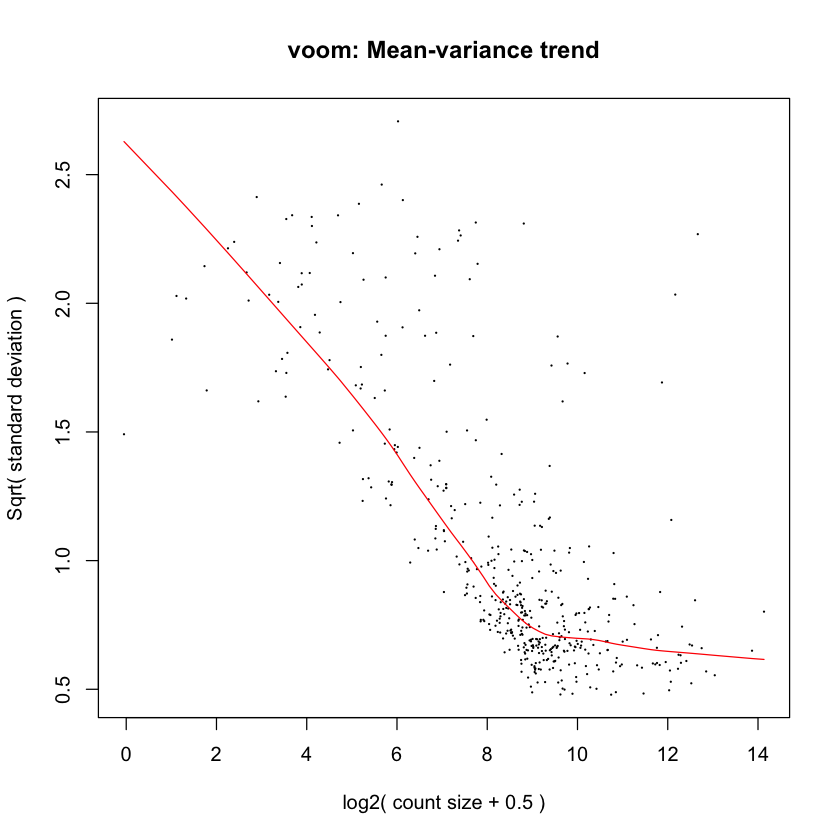

In [80]:
# weighting 
v <- voom(dge, plot=TRUE, normalize="quantile")

In [83]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)

# Apply contrasts
vfit2 <- contrasts.fit(vfit, contrast_matrix)

# Compute the statistics
vfit2 <- eBayes(vfit2)

# Print the top differentially expressed genes for each comparison
TAM_vs_preAML_results <- topTable(vfit2, coef = "TAM_vs_preAML", n=Inf)
TAM_vs_AML_results <- topTable(vfit2, coef = "TAM_vs_AML",n=Inf)
preAML_vs_AML_results <- topTable(vfit2, coef = "preAML_vs_AML",n=Inf)

TAM_vs_preAML_lookup <- rownames(TAM_vs_preAML_results)
TAM_vs_AML_lookup <- rownames(TAM_vs_AML_results)
preAML_vs_AML_lookup <- rownames(preAML_vs_AML_results)

length(TAM_vs_preAML_lookup)
length(TAM_vs_AML_lookup)
length(preAML_vs_AML_lookup)

head(featureData[TAM_vs_preAML_lookup,2])
head(featureData[TAM_vs_AML_lookup,2])
head(featureData[preAML_vs_AML_lookup,2])
head(TAM_vs_preAML_results,10)
head(TAM_vs_preAML_results,10)
head(preAML_vs_AML_results,10)


[1] 481

[1] 481

[1] 481

[1] "MAGED2" "ALOX12" "VCP"    "ANK1"   "CERS2"  "ANK1"

[1] "LAT"  "GAS5" "RPS3" "DMTN" "MYL6" "MYL6"

[1] "RPS3"  "ASAH1" "ASAH1" "ASAH1" "ASAH1" "SNRPB"

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14203,0.6324226,9.659564,4.073856,8.587236e-05,0.0413046,0.757413
6177,3.6648540,4.823726,3.212856,1.709900e-03,0.2375769,-1.486756
13938,0.2592537,9.933532,3.223012,1.655356e-03,0.2375769,-2.090878
13414,1.3111449,7.998166,2.900267,4.476573e-03,0.2375769,-2.315246
820,0.4795482,9.506356,3.081777,2.581631e-03,0.2375769,-2.374579
13415,1.3577567,9.165114,3.034409,2.987182e-03,0.2375769,-2.383404
609,0.5216948,9.884826,2.982159,3.502336e-03,0.2375769,-2.768702
13416,1.3084337,9.053424,2.826972,5.553441e-03,0.2375769,-2.901760
824,2.3318644,6.165166,2.504136,1.369327e-02,0.2375769,-2.950310


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14203,0.6324226,9.659564,4.073856,8.587236e-05,0.0413046,0.757413
6177,3.6648540,4.823726,3.212856,1.709900e-03,0.2375769,-1.486756
13938,0.2592537,9.933532,3.223012,1.655356e-03,0.2375769,-2.090878
13414,1.3111449,7.998166,2.900267,4.476573e-03,0.2375769,-2.315246
820,0.4795482,9.506356,3.081777,2.581631e-03,0.2375769,-2.374579
13415,1.3577567,9.165114,3.034409,2.987182e-03,0.2375769,-2.383404
609,0.5216948,9.884826,2.982159,3.502336e-03,0.2375769,-2.768702
13416,1.3084337,9.053424,2.826972,5.553441e-03,0.2375769,-2.901760
824,2.3318644,6.165166,2.504136,1.369327e-02,0.2375769,-2.950310


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2428,-0.6142684,13.8174188,-3.427688,0.0008483705,0.2040331,-1.439857
13377,-0.9489521,9.4789223,-3.010122,0.0032172502,0.2741909,-2.164916
13386,-1.0766628,9.7864234,-2.979902,0.0035263372,0.2741909,-2.342590
13385,-1.0690676,9.8155944,-2.960150,0.0037429185,0.2741909,-2.404769
13384,-1.0672429,9.8503715,-2.955708,0.0037932766,0.2741909,-2.426801
9366,-5.0383728,0.9168145,-3.747911,0.0002818665,0.1355778,-2.737730
3296,0.9360073,10.6684022,2.849402,0.0052010744,0.2741909,-2.885207
1026,-0.7695298,9.9489388,-2.787676,0.0062237839,0.2741909,-2.899929
3299,0.5351233,10.3483027,2.801815,0.0059745305,0.2741909,-2.958437


In [ ]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

In [ ]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

In [ ]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [ ]:
featureData[head(rownames(significant_expression),5),2]

In [ ]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

In [ ]:
top_significant_genes <- dge[rownames(significant_genes),]

In [ ]:
start=1
stop=length(top_gene_list)
date="2024Jun04_A3SS_voom"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)
violin_plot_filename = piece_exp_filename

In [ ]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


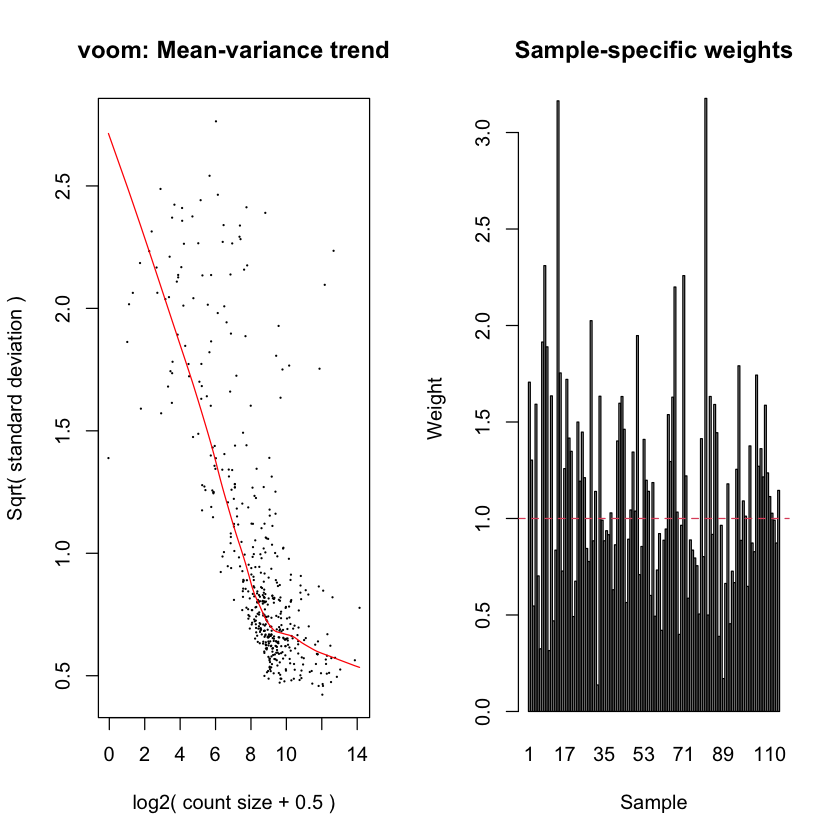

In [86]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [87]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
# no other weighting at this time.
 #* c(1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0))

In [88]:
# Apply contrasts
vwtsfit2 <- contrasts.fit(vwtsfit, contrast_matrix)

# Compute the statistics
vwtsfit2 <- eBayes(vwtsfit2)

# Print the top differentially expressed genes for each comparison
TAM_vs_preAML_results <- topTable(vwtsfit2, coef = "TAM_vs_preAML", n=Inf)
TAM_vs_AML_results <- topTable(vwtsfit2, coef = "TAM_vs_AML",n=Inf)
preAML_vs_AML_results <- topTable(vwtsfit2, coef = "preAML_vs_AML",n=Inf)

TAM_vs_preAML_lookup <- rownames(TAM_vs_preAML_results)
TAM_vs_AML_lookup <- rownames(TAM_vs_AML_results)
preAML_vs_AML_lookup <- rownames(preAML_vs_AML_results)

length(TAM_vs_preAML_lookup)
length(TAM_vs_AML_lookup)
length(preAML_vs_AML_lookup)

head(featureData[TAM_vs_preAML_lookup,2])
head(featureData[TAM_vs_AML_lookup,2])
head(featureData[preAML_vs_AML_lookup,2])
head(TAM_vs_preAML_results,10)
head(TAM_vs_preAML_results,10)
head(preAML_vs_AML_results,10)

[1] 481

[1] 481

[1] 481

[1] "AP2M1"    "OGT"      "PGGHG"    "ARHGEF1"  "RPS15A"   "HLA-DQB1"

[1] "HLA-DQB1" "CCNI"     "CD37"     "CSDE1"    "PTMA"     "CSDE1"

[1] "HLA-DQB1" "RPS3A"    "RPS3"     "CCNI"     "SNRPB"    "PTMA"

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10252,-3.5579461,6.714957,-6.470071,2.577067e-09,1.239569e-06,10.707277
14251,-0.9948991,9.109106,-5.404161,3.640702e-07,8.755889e-05,6.256455
2087,-2.5512746,7.790432,-4.996567,2.136859e-06,2.525556e-04,4.629648
7489,-1.3505530,9.078365,-4.947948,2.625319e-06,2.525556e-04,4.323557
5574,-0.3471896,13.378573,-4.956659,2.530467e-06,2.525556e-04,4.019044
12282,-2.9998843,5.253233,-4.888115,3.376893e-06,2.707143e-04,3.765955
383,-0.5270466,8.900236,-4.751171,5.967768e-06,3.204365e-04,3.699248
2086,-2.6364011,8.142841,-4.750039,5.995693e-06,3.204365e-04,3.601304
2776,-0.5715836,9.718570,-4.752671,5.930989e-06,3.204365e-04,3.524056


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10252,-3.5579461,6.714957,-6.470071,2.577067e-09,1.239569e-06,10.707277
14251,-0.9948991,9.109106,-5.404161,3.640702e-07,8.755889e-05,6.256455
2087,-2.5512746,7.790432,-4.996567,2.136859e-06,2.525556e-04,4.629648
7489,-1.3505530,9.078365,-4.947948,2.625319e-06,2.525556e-04,4.323557
5574,-0.3471896,13.378573,-4.956659,2.530467e-06,2.525556e-04,4.019044
12282,-2.9998843,5.253233,-4.888115,3.376893e-06,2.707143e-04,3.765955
383,-0.5270466,8.900236,-4.751171,5.967768e-06,3.204365e-04,3.699248
2086,-2.6364011,8.142841,-4.750039,5.995693e-06,3.204365e-04,3.601304
2776,-0.5715836,9.718570,-4.752671,5.930989e-06,3.204365e-04,3.524056


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12282,-2.3235376,5.2532331,-4.170031,5.981158e-05,0.01438468,1.4305667
10944,-0.8136499,13.4507662,-4.336776,3.147300e-05,0.01438468,1.3122855
2428,-0.4692608,13.8174188,-3.869263,1.826701e-04,0.02196608,-0.3694135
11211,-6.0765593,4.5128419,-3.381948,9.881578e-04,0.07921731,-0.8196005
9366,-3.6128557,0.9168145,-3.900545,1.630616e-04,0.02196608,-1.4942292
8494,-6.3338971,2.0799091,-3.395222,9.457045e-04,0.07921731,-1.5960497
13377,-0.8605710,9.4789223,-3.197835,1.794645e-03,0.08632242,-1.8000037
13385,-0.9902064,9.8155944,-3.226683,1.636973e-03,0.08632242,-1.8294834
13384,-0.9825644,9.8503715,-3.223629,1.653034e-03,0.08632242,-1.8532807


In [101]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 2
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
TAM_vs_preAML_significant_genes <- TAM_vs_preAML_results[
  abs(TAM_vs_preAML_results$logFC) > fold_change_threshold &
  TAM_vs_preAML_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(TAM_vs_preAML_significant_genes)

[1] 16  6

In [102]:
TAM_vs_preAML_lookup <- rownames(TAM_vs_preAML_significant_genes)
TAM_vs_preAML_significant_expression <- dge[TAM_vs_preAML_lookup,]

In [107]:
TAM_vs_preAML_significant_genes
featureData[rownames(TAM_vs_preAML_significant_expression),2]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10252,-3.557946,6.714957,-6.470071,2.577067e-09,1.239569e-06,10.7072772
2087,-2.551275,7.790432,-4.996567,2.136859e-06,2.525556e-04,4.6296483
12282,-2.999884,5.253233,-4.888115,3.376893e-06,2.707143e-04,3.7659545
2086,-2.636401,8.142841,-4.750039,5.995693e-06,3.204365e-04,3.6013036
9919,-3.455853,8.318684,-4.479498,1.793977e-05,5.376221e-04,2.5518523
6878,-3.852636,4.642827,-3.796651,2.372011e-04,3.127156e-03,0.2330670
193,-2.835182,4.854438,-3.636211,4.174877e-04,4.482734e-03,-0.4174172
1687,-2.024663,4.499742,-3.582623,5.023961e-04,4.931684e-03,-1.1812322
5597,-3.331219,3.634108,-3.416111,8.823443e-04,7.578707e-03,-1.4012104


[1] "AP2M1"    "PGGHG"    "HLA-DQB1" "PGGHG"    "MYH9"     "ACTG1"   
 [7] "LMNA"     "IFIT2"    "RNPS1"    "AKAP8L"   "ANK1"     "CALR"    
[13] "ANK1"     "ANK1"     "CSDE1"    "EIF4G2"

In [97]:
library(pheatmap)

In [98]:
TAM_vs_preAML_significant_out <- pheatmap(TAM_vs_preAML_significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'closure'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'closure'”


ERROR: Error in annotation_col[colnames(mat), , drop = F]: object of type 'closure' is not subsettable


In [99]:
featureData[head(rownames(TAM_vs_preAML_significant_expression),5),2]

[1] "AP2M1"    "PGGHG"    "HLA-DQB1" "PGGHG"    "IFITM1"

In [100]:
top_gene_list <- as.matrix(featureData[rownames(TAM_vs_preAML_significant_expression),2])
length(top_gene_list)

[1] 23

In [ ]:
top_significant_genes <- dge[rownames(significant_genes),]

In [ ]:
start=1
stop=length(top_gene_list)
date="2024Jun04_A3SS_vwts"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)
violin_plot_filename = piece_exp_filename

In [ ]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(outpiece, "2024Jun04_A3SS_vwts_10fold_top_significant_genes.pdf")

In [ ]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


Make violin plots for each of the IDs which are for each row encoded as GeneSymbol.UniqueJunctionIdentifier

In [ ]:
# Load necessary libraries
library(ggplot2)
library(reshape2)
library(dplyr)
library(tidyr)

# Read the CSV file (assuming file path is already defined as violin_plot_filename)
data <- read.csv(violin_plot_filename, stringsAsFactors = FALSE)

# Transform the data from wide to long format
data_long <- melt(data, id.vars = "X", variable.name = "Sample", value.name = "Expression")

# Ensure the Sample column is treated as a character vector
data_long$Sample <- as.character(data_long$Sample)

# Extract individual and state information from Sample column
data_long <- data_long %>%
  mutate(Individual = sapply(strsplit(Sample, "\\."), `[`, 1),
         State = sapply(strsplit(Sample, "\\."), `[`, 2))

# Map state codes to state names
state_mapping <- c("03A" = "TAM", "40A" = "AML")
data_long$State <- state_mapping[data_long$State]

# Calculate the mean differences between AML and TAM for sorting
mean_diffs <- data_long %>%
  group_by(X, State) %>%
  summarise(Mean = mean(Expression), .groups = 'drop') %>%
  pivot_wider(names_from = State, values_from = Mean) %>%
  mutate(Diff = AML - TAM) %>%
  arrange(Diff)

# Store the plots in a list
plots <- list()

# Plot violin plots for each gene symbol and splicing junction identifier in sorted order
for (gene_id in mean_diffs$X) {
  gene_data <- subset(data_long, X == gene_id)
  gene_data$State <- factor(gene_data$State, levels = c("TAM", "AML")) # Ensure TAM is plotted first
  
  mean_TAM <- mean(gene_data$Expression[gene_data$State == "TAM"])
  mean_AML <- mean(gene_data$Expression[gene_data$State == "AML"])
  line_data <- data.frame(State = c("TAM", "AML"), Mean = c(mean_TAM, mean_AML))
  
  p <- ggplot(gene_data, aes(x = State, y = Expression, fill = State)) +
    geom_violin() +
    geom_jitter(width = 0.2, size = 1.5, alpha = 0.6) + # Add individual expression values as dots
    geom_line(aes(group = Individual), color = "blue", alpha = 0.5) + # Line connecting samples of the same individual
    stat_summary(fun = mean, geom = "point", color = "red", size = 3) + # Plot mean as points
    ggtitle(paste("Violin Plot for", gene_id)) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    scale_fill_manual(values = c("TAM" = "skyblue", "AML" = "salmon")) + # Custom colors for states
    geom_line(data = line_data, aes(x = State, y = Mean, group = 1), color = "red", linewidth = 1) # Line connecting means
  
  print(p)  # Print the plot to the notebook
  
  # Save the plot to the list
  plots[[gene_id]] <- p
}
# Load necessary libraries
library(pdftools)

# Directory to save individual PDF files
dir.create("violin_plots")

# Save each plot to a separate PDF file
pdf_files <- c()
for (i in seq_along(plots)) {
  plot_name <- paste0("violin_plots/A3SS_violin_plot_", names(plots)[i], ".pdf")
  ggsave(plot_name, plot = plots[[i]], width = 10, height = 8)
  pdf_files <- c(pdf_files, plot_name)
}

# Combine individual PDF files into a single PDF
pdf_combine(input = pdf_files, output = "A3SS_violin_plots_sorted.pdf")

# Cleanup: remove the individual PDF files
#file.remove(pdf_files)